In [2]:
# post-hoc evaluation of real-time gait event detection from markers script

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt

In [3]:
def getZeroCross(vGRF):
    zero_crossings = np.where(np.diff(np.sign(vGRF-10)))[0] # find index where signal crosses 10N
    return zero_crossings

In [10]:
# create dictionary to save error data

subs = ["s04", "s06", "s07", "s08", "s09", "s10", "s11", "s12", "s13"] #remove s05
cond = ["b", "ti"]
leg = ["R", "L"]

error_dict = dict.fromkeys(subs)

method = 2 #method1 = Zeni HS, method2 = karakskk

In [17]:
# loop through subs and conditions

for i in range(len(subs)):
    error_dict[subs[i]] = dict.fromkeys(cond)
    
    for ii in range(len(cond)):
        error_dict[subs[i]][cond[ii]] = dict.fromkeys(leg)
        
        for iii in range(len(leg)):
    
            #rint("Now starting sub " + subs[i] + " condition " + cond[ii] + " and leg " + leg[iii])
        
            # a. import data
            cal = pd.read_csv(subs[i] + "\\" + subs[i] + "_" + cond[ii] + "_" + leg[iii] + "cal.csv").loc[1000:6000]
            psi = pd.read_csv(subs[i] + "\\" + subs[i] + "_" + cond[ii] + "_" + leg[iii] + "psi.csv").loc[1000:6000]
            toe = pd.read_csv(subs[i] + "\\" + subs[i] + "_" + cond[ii] + "_" + leg[iii] + "toe.csv").loc[1000:6000]
            grf = pd.read_csv(subs[i] + "\\" + subs[i] + "_" + cond[ii] + "_" + leg[iii] + "GRF.csv").loc[1000:6000]

            # b. get zero crossings for ground-truth
            zero_crossings = getZeroCross(grf.values[:,1])
            
            # c. identify which is ground truth is HS and which is TO
            hs_true = np.empty(0)
            to_true = np.empty(0)
            # loop through list of ZC indices
            for j in range(len(zero_crossings)-1):
                # if val(ind+10) > val(ind)+15 then it's HS; add to HS_ind_list
                if grf.values[zero_crossings[j]+10,1]>grf.values[zero_crossings[j],1]+15: 
                    hs_true = np.append(hs_true, zero_crossings[j])
                    # if val(ind+10) <= val(ind) + 15 then it's TO and signal~0
                elif grf.values[zero_crossings[j]+10,1]<=grf.values[zero_crossings[j],1]+15:
                    to_true = np.append(to_true, zero_crossings[j])
                else:
                    print("error??")
                    
            # d. get toe-off
            toePsiDiff = np.zeros(len(cal.values))
            toePsiDiffVel = np.zeros(len(cal.values))
            to_inds = np.empty(0)
            for j in range(1, len(cal.values)): #start with second data point
                toePsiDiff[j] = toe.values[j,2] - psi.values[j,2]
                toePsiDiffVel[j] = toePsiDiff[j]-toePsiDiff[j-1]

                if j>3:
                    if toePsiDiffVel[j]>=0 and toePsiDiffVel[j-1]<=0 and toePsiDiffVel[j-2]<=0 and toePsiDiffVel[j-3]<=0: 
                        to_inds = np.append(to_inds, j-1)   
                        
            
            # e. get heel-strike
            
            # method 1: (Zeni)
            if method == 1:
                hs_inds = np.empty(0)
                for j in range(1, len(cal.values)): #start with second data point
                    # local max
                    if toePsiDiffVel[j]<=0 and toePsiDiffVel[j-1]>=0 and toePsiDiffVel[j-2]>=0 and toePsiDiffVel[j-3]>=0: 
                        hs_inds = np.append(hs_inds, j-1) 
            
            # method 2: 
            if method == 2:
                cal_Vvel = np.zeros(len(cal.values))
                cal_Hvel = np.zeros(len(cal.values))
                hs_inds = np.empty(0)
                y_GM = 0.1 #might need to tune this; global maximum
                flag = 0
                for j in range(1, len(cal.values)): #start with second data point
                    cal_Vvel[j] = cal.values[j,1] - cal.values[j-1,1] #calc velocity sign
                    cal_Hvel[j] = cal.values[j,0] - cal.values[j-1,0] #horizontal vel

                    # get to 5th data point
                    if j>4:
                        if cal_Vvel[j]<0 and cal_Vvel[j-1]<0 and cal_Vvel[j-2]>=0 and cal_Vvel[j-3]>=0 and cal.values[j-2,1]>y_GM:
                            # then k-2 is global max; now look for min
                            flag = 1

                        if flag:
                            if cal_Vvel[j]>=0 and cal_Vvel[j-1]<=0 and cal_Vvel[j-2]<=0 and cal_Vvel[j-3]<=0:            
                            # then k-1 is local min (Hs)
                                hs_inds = np.append(hs_inds,j-1)
                                flag = 0
                            

                        
                        
            # f. make lengths same
            
            # heel strike
            if hs_inds[0] + 20 < hs_true[0]:
                hs_inds = hs_inds[1:]
            if hs_true[0] + 20 < hs_inds[0]:
                hs_true = hs_true[1:]
            if hs_inds[-1] -20 > hs_true[-1]:
                hs_inds = hs_inds[0:-1]
            if hs_true[-1] -20 > hs_inds[-1]:
                hs_true = hs_true[0:-2]
            
            # toe off
            if to_inds[0] + 20 < to_true[0]:
                to_inds = to_inds[1:]
            if to_true[0] + 20 < to_inds[0]:
                to_true = to_true[1:]
            if to_inds[-1] -20 > to_true[-1]:
                to_inds = to_inds[0:-1]
            if to_true[-1] -20 > to_inds[-1]:
                to_true = to_true[0:-1]
                
                        
            # g. combine to final dictionary
            try:
                abs_error_hs = hs_true - hs_inds
            except ValueError:
                print('some kind of error (HS) for sub ' + str(subs[i]) + ', cond: ' + str(cond[ii]) + str(leg[iii]))
                pass  # do nothing!
            
            try:
                abs_error_to = to_true-to_inds
            except ValueError:
                print('some kind of error (TO)for sub ' + str(subs[i]) + ', cond: ' + str(cond[ii]) + str(leg[iii]))
                pass  # do nothing!

        
            
            error_dict[subs[i]][cond[ii]][leg[iii]] = [abs_error_hs, abs_error_to]
            


some kind of error (HS) for sub s06, cond: bL


In [8]:
error_dict

{'s04': {'b': {'R': [array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,
           -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
    array([2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 3., 1., 2., 2., 2., 2., 2.,
           2., 2., 1., 2., 2., 1., 2., 1., 1., 2., 2., 2., 2., 1., 2., 2., 2.,
           2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 1., 1., 2., 2.])],
   'L': [array([-1., -1.,  0.,  0., -1., -1., -1., -1.,  0., -1., -1.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
            0.,  0.,  0., -1.,  5.,  0.,  0.,  0.,  5., -1.,  0.,  0.,  0.,
            0.,  0.,  0.,  6.,  0.,  0.,  1.,  0.,  5.]),
    array([2., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 1.,
           2., 1., 2., 1., 2., 1., 2., 1., 2., 2., 2., 1., 1., 2., 1., 1., 1.,
           

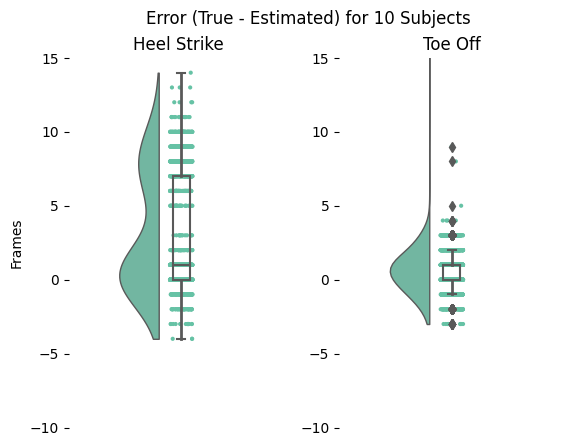

In [12]:
# loop through all error 
total_error_hs = np.empty([0])

for i in range(len(subs)):    
    for ii in range(len(cond)):
        for iii in range(len(leg)):
                total_error_hs = np.append(total_error_hs, error_dict[subs[i]][cond[ii]][leg[iii]][0])
            
total_error_to = np.empty([0])

for i in range(len(subs)):    
    for ii in range(len(cond)):
        for iii in range(len(leg)):
                total_error_to = np.append(total_error_to, error_dict[subs[i]][cond[ii]][leg[iii]][1])
            
            
fig = plt.subplot(1,2,1)
plt.suptitle('Error (True - Estimated) for 10 Subjects')
pt.RainCloud(np.ones(len(total_error_hs)),total_error_hs, bw=0.5)
ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([-10,15])
plt.ylabel('Frames')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Heel Strike ')

plt.subplot(1,2,2)
pt.RainCloud(np.ones(len(total_error_to)),total_error_to, bw=0.5)
ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([-10,15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Toe Off')

plt.savefig('error_HSTO_all.svg', format='svg', dpi=1200)
plt.show()




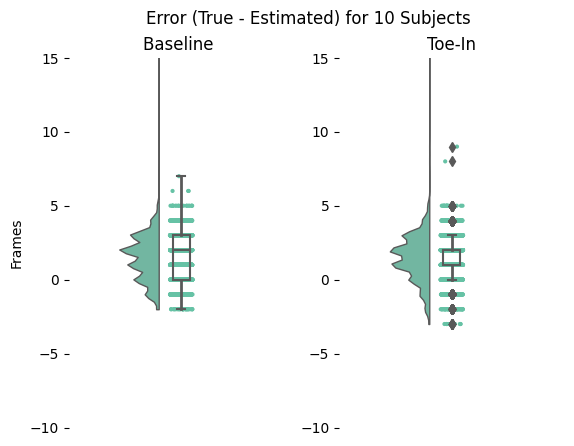

In [8]:
# comparing error for baseline vs toe-in

total_error_b = np.empty([0])

for i in range(len(subs)):    
        for iii in range(len(leg)):
            
            total_error_b = np.append(total_error_b, error_dict[subs[i]][cond[0]][leg[iii]][0])
            total_error_b = np.append(total_error_b, error_dict[subs[i]][cond[0]][leg[iii]][1])
            
total_error_ti = np.empty([0])

for i in range(len(subs)):    
        for iii in range(len(leg)):
            
            total_error_ti = np.append(total_error_ti, error_dict[subs[i]][cond[1]][leg[iii]][0])
            total_error_ti = np.append(total_error_ti, error_dict[subs[i]][cond[1]][leg[iii]][1])
            
            
plt.subplot(1,2,1)
plt.suptitle('Error (True - Estimated) for 10 Subjects')
pt.RainCloud(np.ones(len(total_error_b)),total_error_b)
ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([-10,15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.ylabel('Frames')
plt.title('Baseline ')

plt.subplot(1,2,2)
pt.RainCloud(np.ones(len(total_error_ti)),total_error_ti)
ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([-10,15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Toe-In')

plt.savefig('error_BaTi_all.svg', format='svg', dpi=1200)
plt.show()



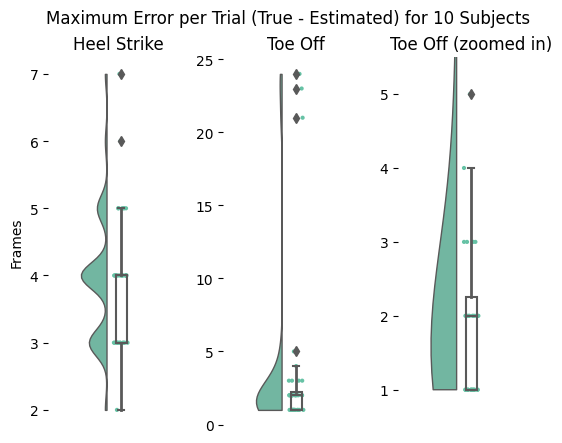

In [9]:
# worst case error for each sub
total_error_hs = np.empty([0])

for i in range(len(subs)):    
    for ii in range(len(cond)):
        for iii in range(len(leg)):
                total_error_hs = np.append(total_error_hs, np.max(np.abs(error_dict[subs[i]][cond[ii]][leg[iii]][0])))
            
total_error_to = np.empty([0])

for i in range(len(subs)):    
    for ii in range(len(cond)):
        for iii in range(len(leg)):
                total_error_to = np.append(total_error_to, np.max(np.abs(error_dict[subs[i]][cond[ii]][leg[iii]][1])))
            
            
plt.subplot(1,3,1)
plt.suptitle('Maximum Error per Trial (True - Estimated) for 10 Subjects')
pt.RainCloud(np.ones(len(total_error_hs)),total_error_hs)
ax = plt.gca()
ax.set_xlim([-1, 1])
#ax.set_ylim([-10,15])
plt.ylabel('Frames')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Heel Strike ')

plt.subplot(1,3,2)
pt.RainCloud(np.ones(len(total_error_to)),total_error_to)
ax = plt.gca()
ax.set_xlim([-1, 1])
#ax.set_ylim([-10,15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Toe Off')

plt.subplot(1,3,3)
pt.RainCloud(np.ones(len(total_error_to)),total_error_to)
ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([0.5,5.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
plt.title('Toe Off (zoomed in)')

plt.savefig('maxerror_HSTO_all.svg', format='svg', dpi=1200)
plt.show()

